# Introductory applied machine learning (INFR10069) 

# Lab 2: Decision trees and linear regression

In the first part of this lab we perform Decision trees classification on the [German credit](http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) data set. In the second part we learn how to train simple linear regression model by using the [CPU performance](https://archive.ics.uci.edu/ml/datasets/Computer+Hardware) data set. Both datasets (`credit.csv` and `cpu.csv`) are located at the `./datasets` directory which is adjacent to this file.

First, we're going to intall a new package to visulaize trees. Run the following commands in your terminal to install (remember to exclude 'source' if you're on windows):

```{bash}
source activate iaml
conda install python-graphviz
```

If this causes issue, it's not essential. Simply exclude commands involving graphviz.

Now let's import the packages:

In [1]:
# Import packages
from __future__ import division, print_function # Imports from __future__ since we're running Python 2
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
%matplotlib inline

## 1. Decision Trees
One of the great advantages of decision trees is their interpretability. The rules learnt for classification are easy for a person to follow, unlike the opaque "black box" of many other methods, such as neural networks. We demonstrate the utility of this using a German credit data set. You can read a description of this dataset at the [UCI site](http://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29). The task is to predict whether a loan approval is good or bad credit risk based on 20 attributes. We've simplified the data set somewhat, particularly making attribute names and values more meaningful.

Download the dataset and save it in a directory called `datasets` in the same folder that your notebooks live. Alternatively, you can save the dataset in any folder you wish and modify the `data_path` variable below accordingly. We will load our data into a pandas DataFrame structure. 

In [2]:
data_path = os.path.join(os.getcwd(), 'datasets', 'credit.csv')
credit = pd.read_csv(data_path, delimiter = ',')
data_path = os.path.join(os.getcwd(), 'datasets', 'cpu.csv')
cpu = pd.read_csv(data_path, delimiter = ',')

### ========== Question 1.1 ==========
Display the number of data points and attributes in the dataset. 

In [3]:
print("credit data points, attributes: ", np.subtract(credit.shape,(0,1)))

credit data points, attributes:  [1001   20]


### ========== Question 1.2 ==========
Get a feeling of the data by using pandas `describe()` method. Be careful - there is a mixture of numeric and categorical data...

In [4]:
credit.describe()

,Duration,CreditAmount,InstallmentRate,ResidentSince,Age,NumCreditsAtBank,Dependents
count,1001.000000,1.001000e+03,1001.000000,1001.000000,1001.000000,1001.000000,1001.000000
mean,20.882118,-9.957330e+05,-7.019980,2.842158,35.217782,0.406593,0.969031
std,12.070878,3.160708e+07,316.165715,1.106825,15.398264,31.656714,5.894916
min,0.000000,-1.000000e+09,-10000.000000,0.000000,-293.000000,-1000.000000,-185.000000
25%,12.000000,1.364000e+03,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2.319000e+03,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3.972000e+03,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,1.842400e+04,4.000000,4.000000,75.000000,4.000000,2.000000


### ========== Question 1.3 ==========
Display the first 10 data points of the dataset

In [5]:
credit[:10]

,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,YearsEmployed,InstallmentRate,PersonalStatus,OtherDebtors,...,Property,Age,OtherPlans,Housing,NumCreditsAtBank,Job,Dependents,Telephone,Foreign,Approve
0,<0,0.0,ok,furniture,-1.000000e+09,unknown,unemployed,-10000.0,female_single,none,...,car,-293.0,none,own,-1000.0,skilled,-185.0,yes,no,good
1,<0,6.0,critical,television,1.169000e+03,unknown,>=7,4.0,male_single,none,...,real_estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
2,<200,48.0,ok_til_now,television,5.951000e+03,<100,<4,2.0,female,none,...,real_estate,22.0,none,own,1.0,skilled,1.0,no,yes,bad
3,none,12.0,critical,education,2.096000e+03,<100,<7,2.0,male_single,none,...,real_estate,49.0,none,own,1.0,unskilled,2.0,no,yes,good
4,<0,42.0,ok_til_now,furniture,7.882000e+03,<100,<7,2.0,male_single,guarantor,...,savings,45.0,none,free,1.0,skilled,2.0,no,yes,good
5,<0,24.0,past_delays,car_new,4.870000e+03,<100,<4,3.0,male_single,none,...,unknown,53.0,none,free,2.0,skilled,2.0,no,yes,bad
6,none,36.0,ok_til_now,education,9.055000e+03,unknown,<4,2.0,male_single,none,...,unknown,35.0,none,free,1.0,unskilled,2.0,yes,yes,good
7,none,24.0,ok_til_now,furniture,2.835000e+03,<1000,>=7,3.0,male_single,none,...,savings,53.0,none,own,1.0,skilled,1.0,no,yes,good
8,<200,36.0,ok_til_now,car_used,6.948000e+03,<100,<4,2.0,male_single,none,...,car,35.0,none,rent,1.0,management,1.0,yes,yes,good
9,none,12.0,ok_til_now,television,3.059000e+03,>=1000,<7,2.0,male_divorced,none,...,real_estate,61.0,none,own,1.0,unskilled,1.0,no,yes,good


### ========== Question 1.4 ==========
When presented with a dataset, it is usually a good idea to visualise it first. By using seaborn's [pairplot](https://seaborn.github.io/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) function, try visualising a scatter plot of the `Age` and `Duration` variables. You can use the `Approve` variable as the `hue` parameter to visualise results separately for each class. Do you notice anything unusual?

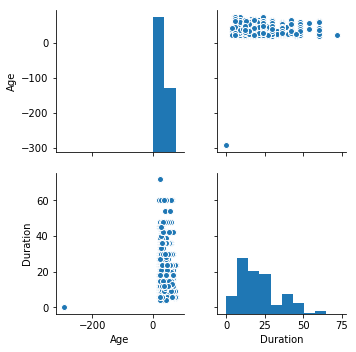

In [6]:
ax = sns.pairplot(credit, vars=["Age", "Duration"])

There is an outlier with age data -300.

### ========== Question 1.5 ==========
In the previous point you should have found a data point, which seems to be corrupted, as some of its values are nonsensical. Even a single point like this can significantly affect the performance of a classifier. How do you think it would affect Decision trees? How about Naive Bayes? A good way to check this is to test the performance of each classifier before and after removing this datapoint.

Decision Tree are not sensitive to median of the values, it's based on the split range, not actual values.

Naive Bayes will be affected as the center of the data is moved away from the cluster, resulting in poor performance in classification.

### ========== Question 1.6 ==========
Now we want to remove this instance from the dataset by using a filter. We want to remove all instances, where the age of an applicant is lower than 0 years, as this suggests that the instance is corrupted. Use logical indexing to get rid of these instances without creating a new dataframe. Display the number of data points after any outliers have been removed.

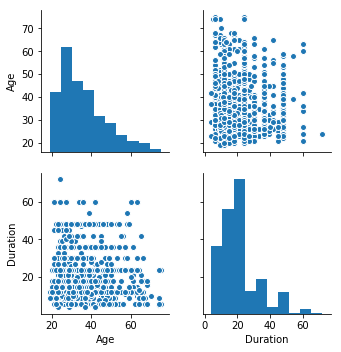

In [7]:
credit = credit[credit['Age']>=0]
ax = sns.pairplot(credit, vars=["Age", "Duration"])

### ========== Question 1.7 ==========

You might have noticed that most of the attributes in the dataset are in fact discrete. Now we want to know which variables exactly are discrete (both categorical and numerical, look [here](http://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data) if you are unsure about the difference) and which are continuous variables. In order to do so, we will inspect the number of possible values that each attribute can take. 

Display the number of values each attributes takes in the dataset. *Hint: As a first step, you want to loop over the columns of the DataFrame. Then you might find the numpy `unique` function quite useful.*

In [8]:
credit_clean = credit.copy()
mask = (np.full(credit.shape[0],True))
for column in credit_clean.columns:
    if credit_clean[column].dtype == np.float64:
        mask = mask & (credit_clean[column] >= 0) #Keep Range
credit_clean = credit_clean[mask]
credit_clean

,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,YearsEmployed,InstallmentRate,PersonalStatus,OtherDebtors,...,Property,Age,OtherPlans,Housing,NumCreditsAtBank,Job,Dependents,Telephone,Foreign,Approve
1,<0,6.0,critical,television,1169.0,unknown,>=7,4.0,male_single,none,...,real_estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
2,<200,48.0,ok_til_now,television,5951.0,<100,<4,2.0,female,none,...,real_estate,22.0,none,own,1.0,skilled,1.0,no,yes,bad
3,none,12.0,critical,education,2096.0,<100,<7,2.0,male_single,none,...,real_estate,49.0,none,own,1.0,unskilled,2.0,no,yes,good
4,<0,42.0,ok_til_now,furniture,7882.0,<100,<7,2.0,male_single,guarantor,...,savings,45.0,none,free,1.0,skilled,2.0,no,yes,good
5,<0,24.0,past_delays,car_new,4870.0,<100,<4,3.0,male_single,none,...,unknown,53.0,none,free,2.0,skilled,2.0,no,yes,bad
6,none,36.0,ok_til_now,education,9055.0,unknown,<4,2.0,male_single,none,...,unknown,35.0,none,free,1.0,unskilled,2.0,yes,yes,good
7,none,24.0,ok_til_now,furniture,2835.0,<1000,>=7,3.0,male_single,none,...,savings,53.0,none,own,1.0,skilled,1.0,no,yes,good
8,<200,36.0,ok_til_now,car_used,6948.0,<100,<4,2.0,male_single,none,...,car,35.0,none,rent,1.0,management,1.0,yes,yes,good
9,none,12.0,ok_til_now,television,3059.0,>=1000,<7,2.0,male_divorced,none,...,real_estate,61.0,none,own,1.0,unskilled,1.0,no,yes,good
10,<200,30.0,critical,car_new,5234.0,<100,unemployed,4.0,male_married,none,...,car,28.0,none,own,2.0,management,1.0,no,yes,bad


It seems like the variables `Duration`, `CreditAmount` and `Age` are continuous and all the rest are discrete. The discrete variables are not in a very convenient format though. Ideally we would want the discrete attributes to take values between `0` and `n_values-1`. Scikit-learn has a handy [`LabelEncoder`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn.preprocessing.LabelEncoder) implementation which can do that for us. You are encouraged to read its documentation.

Now we will create a new DataFrame called `credit_clean` and convert all the discrete variables from `credit` by using a `LabelEncoder`. Remember, we want to change the discrete variables only, so we will have to exclude the `CreditAmount`, `Age` and `Duration` attributes. Also, we don't really mind if the target variable is categorical, so we won't be transforming the `Approve` attribute either. Execute the cell below and make sure you understand what it does.

In [9]:
le_dict = dict() # Initialise an empty dictionary to keep all LabelEncoders
credit_clean = credit.copy(deep=True) # Make a copy of the DataFrame
# Loop over attributes by excluding the ones that are continuous and the target variable
for column in credit_clean.drop(['CreditAmount', 'Age', 'Duration', 'Approve'], axis=1):  
    le = LabelEncoder().fit(credit[column]) # Initialise the LabelEncoder and fit
    credit_clean[column] = le.transform(credit[column]) # Transform data and save in credit_clean DataFrame
    le_dict[column] = le # Store the LabelEncdoer in dictionary

### ========== Question 1.8 ==========
Display the first 10 data points of the clean data. Does it look like what you expected?

In [10]:
credit_clean[:10]

,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,YearsEmployed,InstallmentRate,PersonalStatus,OtherDebtors,...,Property,Age,OtherPlans,Housing,NumCreditsAtBank,Job,Dependents,Telephone,Foreign,Approve
1,0,6.0,0,9,1169.0,4,3,3,3,2,...,1,67.0,1,1,1,1,0,1,1,good
2,1,48.0,3,9,5951.0,0,1,1,0,2,...,1,22.0,1,1,0,1,0,0,1,bad
3,3,12.0,0,4,2096.0,0,2,1,3,2,...,1,49.0,1,1,0,3,1,0,1,good
4,0,42.0,3,5,7882.0,0,2,1,3,1,...,2,45.0,1,0,0,1,1,0,1,good
5,0,24.0,4,2,4870.0,0,1,2,3,2,...,3,53.0,1,0,1,1,1,0,1,bad
6,3,36.0,3,4,9055.0,4,1,1,3,2,...,3,35.0,1,0,0,3,1,1,1,good
7,3,24.0,3,5,2835.0,1,3,2,3,2,...,2,53.0,1,1,0,1,0,0,1,good
8,1,36.0,3,3,6948.0,0,1,1,3,2,...,0,35.0,1,2,0,0,0,1,1,good
9,3,12.0,3,9,3059.0,3,2,1,1,2,...,1,61.0,1,1,0,3,0,0,1,good
10,1,30.0,0,2,5234.0,0,4,3,2,2,...,0,28.0,1,1,1,0,0,0,1,bad


### ========== Question 1.9 ==========
Store the input features (i.e. attributes) into a matrix `X` and the target variable (`Approve`) into a vector `y`. Remember to not include the target variable into `X`. *Hint: You can either use pandas `as_matrix()` or `values`.* 

Display the shapes of `X` and `y`. Confirm that you have 20 input features, one target variable and 1000 data points.

In [11]:
X = credit_clean.drop(['Approve'],1).values
y = credit_clean['Approve'].values
print("Shape of X: ",X.shape)
print("Shape of y: ",y.shape)

Shape of X:  (1000, 20)
Shape of y:  (1000,)


## Hold-out validation
In the next step we will be using a Decision Tree classifier model. To get an accurate estimate of the model's classification performance we will use hold-out validation. Familiriase yourself with the logic behind [`train_test_split CV`](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-evaluating-estimator-performance) (also called `Hold-out` validation) and [how it is used](http://scikit-learn.org/0.16/modules/generated/sklearn.cross_validation.train_test_split.html) in `Scikit-learn`. Execute the cell below to create your training/testing sets by assigning 10% of the data to the test set (and convince yourself you understand what is going on).

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, test_size=0.1, random_state=0)

### ========== Question 1.10 ==========
Confirm that `X_train` and `X_test` matrices are subsets of `X` by displaying the number of rows in the three matrices (no need to make use of set theory).

In [13]:
print("Shape of X_train: ",X_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of X: ",X.shape)

Shape of X_train:  (900, 20)
Shape of X_test:  (100, 20)
Shape of X:  (1000, 20)


### ========== Question 1.11 ==========
Now we will train a Decision Tree classifier on the training data. Read about [Decision Tree classifiers](http://scikit-learn.org/stable/modules/tree.html) in `Scikit-learn` and how they are [used](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier). 
Create a `DecisionTreeClassifier` instance and train it by using training data only (i.e. `X_train` and `y_tain`). Set the `criterion` attribute to `entropy` in order to measure the quality of splits by using the information gain. Use the default settings for the rest of parameters. By default, trees are grown to full depth; this means that very fine splits are made involving very few data points. Not only does this make the trees hard to visualise (they'll be deep), but also we could be overfitting the data. For now, we arbitrarily choose a depth of 2 for our tree, but this is a parameter we could tune.

In [14]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=2)
dt.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

We have mentioned in the class that decision trees have the advantage of being interpretable by humans. Now we visualise the decision tree we have just trained. Scikit-learn can export the tree in a `.dot` format. 

An alternative way to visualise the tree is to open the output .dot file with an editor such as [this online .dot renderer](http://dreampuf.github.io/GraphvizOnline/). You can copy and paste the dot file in and view online (you can double click on the tree once it has been produced to view it in full screen).

This code below should work if you created a decision tree classifier object called `dt`.

In [15]:
dot_data = tree.export_graphviz(dt, out_file=None, 
    feature_names=credit_clean.drop('Approve', axis=1).columns,  
    class_names=credit_clean['Approve'].unique(),  
    filled=True, rounded=True,  
    special_characters=True)
graph = graphviz.Source(dot_data)

with open("tree.dot", 'w') as f:
    f = export_graphviz(dt, out_file=f,
                        feature_names=credit_clean.drop('Approve', axis=1).columns,  
                        class_names=credit_clean['Approve'].unique(),  
                        filled=True, rounded=True,  
                        special_characters=True)

## To create a file do this:
# with open("tree.dot", 'w') as f:
#     f = export_graphviz(dt, out_file=f,
#                         feature_names=credit_clean.drop('Approve', axis=1).columns,  
#                         class_names=credit_clean['Approve'].unique(),  
#                         filled=True, rounded=True,  
#                         special_characters=True)

### ========== Question 1.12 ==========
Inspect the tree. Describe what it shows. Which attribute yields the highest information gain and what is its critical value?

Approved ones mostly have CheckingAccount < 1.5, and Duration > 22.5.

Checking Account gives highest information gain. Critical value 1.5.

### ========== Question 1.13 ==========
Tree-based estimators (i.e. decision trees and random forests) can be used to compute feature importances. The importance of a feature is computed as the (normalized) total reduction of entropy (or other used `criterion`) brought by that feature. Find the relevant attribute of the classifier you just trained and display feature importances along with their names.

In [16]:
fs = np.vstack((credit_clean.columns.drop(['Approve']), dt.feature_importances_))
pd.DataFrame(fs)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,YearsEmployed,InstallmentRate,PersonalStatus,OtherDebtors,ResidentSince,Property,Age,OtherPlans,Housing,NumCreditsAtBank,Job,Dependents,Telephone,Foreign
1,0.752003,0.153697,0,0,0,0,0,0,0,0,0,0,0,0.0942994,0,0,0,0,0,0


### ========== Question 1.14 ==========
Now we want to evaluate the performance of the classifier on unseen data. Use the trained model to predict the target variables for the test data set. Display the classification accuracy for both the training and test data sets. What do you observe? Are you surprised by the results?

In [17]:
dt.score(X_test,y_test)

0.72999999999999998

Not really, done in assignment 1

### ========== Question 1.15 ==========

Fit another `DecisionTreeClassifier` but this time grow it to full depth (i.e. remove the max_depth condition. Display the classification accuracy for training and test data as above. Again, what do you observe and are you surprised?

In [18]:
dt2 = DecisionTreeClassifier(criterion='entropy')
dt2.fit(X_train,y_train)
print(dt2.score(X_train,y_train))
print(dt2.score(X_test,y_test))

1.0
0.67


not reelly, 1.0 score because trained on it, greedy makes it perform worse on deeper tree.

### ========== Question 1.16 ==========
By using seaborn's heatmap function, plot the normalised confusion matrices for both the training and test data sets **for the max_depth=2 decision tree from question 1.11**. Make sure you label axes appropriately. *Hint: You can make use of the `plot_confusion_matrix` function introduced in Lab_2.*

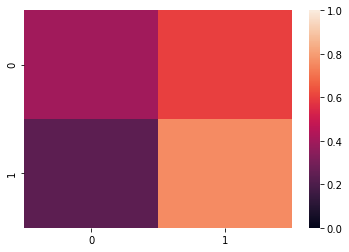

In [19]:
cfsmt = confusion_matrix(y_test,dt2.predict(X_test))
normie = cfsmt / cfsmt.sum(1)[:, np.newaxis]
b = sns.heatmap(normie, vmin=0., vmax=1)

### ========== Question 1.17 ==========

Finally we will create a [`Random decision forest`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier and compare the performance of this classifier to that of the decision tree. The random decision forest is an ensemble classifier that consists of many decision trees and outputs the class that is the mode of the class's output by individual trees. Start with `n_estimators = 100`, use the `entropy` criterion and the same train/test split as before. Plot the classification accuracy of the random forest model on the test set and show the confusion matrix. How does the random decision forest compare performance wise to the decision tree?

In [20]:
rf = RandomForestClassifier(n_estimators = 100).fit(X_train, y_train)
rf.score(X_test,y_test)

0.77000000000000002

### ========== Question 1.18 ==========
How high can you get the performance of the classifier by changing the max depth of the trees (`max_depth`), or the `max_features` parameters? Try a few values just to get a look. *Don't do a grid search or anything in-depth, just get a feel*. Try the same settings twice...do you get the same accuracy?

In [21]:
rf = RandomForestClassifier(n_estimators = 100, max_depth=2,max_features=2).fit(X_train, y_train)
rf.score(X_test,y_test)

0.75

### ========== Question 1.19 ==========
Compare the feature importances as estimated with the decision tree and random forest classifiers.

In [22]:
fs = np.vstack((credit_clean.columns.drop(['Approve']), dt.feature_importances_, rf.feature_importances_))
pd.DataFrame(fs)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,CheckingAccount,Duration,CreditHistory,Purpose,CreditAmount,SavingsAccount,YearsEmployed,InstallmentRate,PersonalStatus,OtherDebtors,ResidentSince,Property,Age,OtherPlans,Housing,NumCreditsAtBank,Job,Dependents,Telephone,Foreign
1,0.752003,0.153697,0,0,0,0,0,0,0,0,0,0,0,0.0942994,0,0,0,0,0,0
2,0.191609,0.103709,0.0784508,0.0499912,0.0920177,0.09534,0.0361116,0.018371,0.0254859,0.00979945,0.00620416,0.0765052,0.0626451,0.0361989,0.0634452,0.0116335,0.010585,0.00407592,0.0169237,0.0108974


## 2. Linear regression
In the second part of the lab we use the [CPU performance](https://archive.ics.uci.edu/ml/datasets/Computer+Hardware) dataset for a simple regression task. Famliarise yourself with the dataset before moving on to the next step. Note that the version we will be using is missing the `Model Name` and `PRP` attributes. Our task will be to use the remaining attributes to predict `ERP` values.

Download the dataset and save it in a directory called `datasets` in the same folder that your notebooks live. Alternatively, you can save the dataset in any folder you wish and modify the `data_path` variable below accordingly. We will load our data into a pandas DataFrame structure. 

In [23]:
# Load the dataset
data_path = os.path.join(os.getcwd(), 'datasets', 'cpu.csv')
cpu = pd.read_csv(data_path, delimiter = ',')

### ========== Question 2.1 ==========
Display the number of data points and attributes in the dataset. 

In [24]:
print("cpu data points, attributes: ", np.subtract(cpu.shape,(0,1)))

cpu data points, attributes:  [209   7]


### ========== Question 2.2 ==========
Get a feeling of the data by using pandas `describe()` method. 

In [25]:
cpu.describe()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,ERP
count,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000,209.000000
mean,203.822967,2867.980861,11796.153110,25.205742,4.698565,18.267943,99.330144
std,260.262926,3878.742758,11726.564377,40.628722,6.816274,25.997318,154.757102
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,15.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,28.000000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,45.000000
75%,225.000000,4000.000000,16000.000000,32.000000,6.000000,24.000000,101.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1238.000000


### ========== Question 2.3 ==========
Display the first 10 data points of the dataset

In [26]:
cpu[:10]

,vendor,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,ERP
0,adviser,125.0,256.0,6000.0,256.0,16.0,128.0,199.0
1,amdahl,29.0,8000.0,32000.0,32.0,8.0,32.0,253.0
2,amdahl,29.0,8000.0,32000.0,32.0,8.0,32.0,253.0
3,amdahl,29.0,8000.0,32000.0,32.0,8.0,32.0,253.0
4,amdahl,29.0,8000.0,16000.0,32.0,8.0,16.0,132.0
5,amdahl,26.0,8000.0,32000.0,64.0,8.0,32.0,290.0
6,amdahl,23.0,16000.0,32000.0,64.0,16.0,32.0,381.0
7,amdahl,23.0,16000.0,32000.0,64.0,16.0,32.0,381.0
8,amdahl,23.0,16000.0,64000.0,64.0,16.0,32.0,749.0
9,amdahl,23.0,32000.0,64000.0,128.0,32.0,64.0,1238.0


### ========== Question 2.4 ========== 
You might have noticed that the `vendor` attribute is categorical. This will give problems when using a linear regression model. For now we can simply remove this attribute. Create a new DataFrame called `cpu_clean` by copying `cpu` but omit the `vendor` attribute. Display the number of samples and attributes in the clean dataset as a sanity check.

In [27]:
cpu_clean = cpu.drop(['vendor'],axis=1,inplace=False)
cpu_clean

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,ERP
0,125.0,256.0,6000.0,256.0,16.0,128.0,199.0
1,29.0,8000.0,32000.0,32.0,8.0,32.0,253.0
2,29.0,8000.0,32000.0,32.0,8.0,32.0,253.0
3,29.0,8000.0,32000.0,32.0,8.0,32.0,253.0
4,29.0,8000.0,16000.0,32.0,8.0,16.0,132.0
5,26.0,8000.0,32000.0,64.0,8.0,32.0,290.0
6,23.0,16000.0,32000.0,64.0,16.0,32.0,381.0
7,23.0,16000.0,32000.0,64.0,16.0,32.0,381.0
8,23.0,16000.0,64000.0,64.0,16.0,32.0,749.0
9,23.0,32000.0,64000.0,128.0,32.0,64.0,1238.0


### ========== Question 2.5 ==========
Now -as always- we want to perform some exploratory data analysis. Remember that our task is to predict `ERP` values, so it's a good idea to inspect individual scatter plots of the target variable (`ERP`) against our input features. For this purpose we will use once again seaborn's pairplot implementation.

Create a series of [pairplots](https://seaborn.github.io/generated/seaborn.pairplot.html?highlight=pairplot#seaborn.pairplot) showing the pairwise relationship of `ERP` and the remaining attributes in the data. You can do so by specifying explicitly the `x_vars` and `y_vars` input arguments in the pairplot. *Hnt: Your final plot will consist of 6 subplots each contaning a scatter plot.*

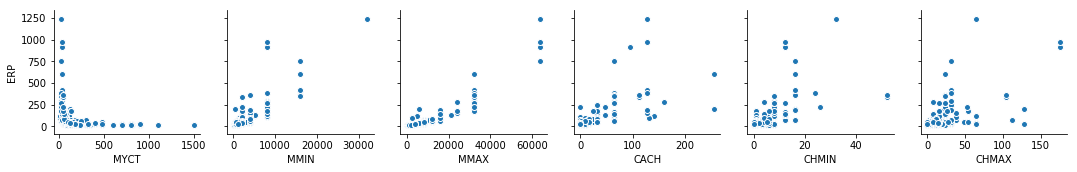

In [28]:
ax = sns.pairplot(cpu, x_vars=cpu_clean.columns.drop(['ERP']), y_vars=['ERP'])

### ========== Question 2.6 ==========
* Do you think that ERP should be at least partially predictable from the input attributes?
* Do any attributes exhibit significant correlations?

MYCT looks have some relationship, somehow

### ========== Question 2.7 ==========
Now we have a feel for the data and we will try fitting a simple linear regression model. Similarly to what we did in the first part of the lab, we want to use cross-validation to evaluate the goodness of the fit.

By using the `cpu_clean` dataset extract the raw values for the input features and the target variable and store them in two matrices, called `X` and `y` respectively. 

Then, split the dataset into training and testing sets by using a 75%-25% split (training/testing).

Display the shapes of all matrices involved and double-check that all dimensionalities appear to be as expected.

In [29]:
X = cpu_clean.drop(['ERP'],1).values
y = cpu_clean['ERP'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.75, test_size=0.25, random_state=0)

### ========== Question 2.8 ==========
Fit a simple linear regressor by using the [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) model in Scikit-learn. Report the training accuracy by using the `score` attribute. What does this represent?

In [30]:
lr = LinearRegression()
lr.fit(X_train,y_train)
lr.score(X_test,y_test)

0.85678728228685008

How close the estimate is.

### ========== Question 2.9 ==========
Now report the testing accuracy by using the `score` attribute of the regressor as well as the `r2_score` metric. Confirm that these two yield identical results.

How does the accuracy compare to the one reported on the training dataset? Do you think that your model does well on generalising on unseen data? 

In [31]:
print(r2_score(y_test,lr.predict(X_test)))
print(lr.score(X_train,y_train))

0.856787282287
0.915904252607


ZE ZKORE IZ DE ZAME!

Accuracy is lower of course.
'kay I fink

### ========== Question 2.10 ==========
Now we want to get a feel for how good the fit is, so we wil plot the measured values against the predicted ones. Make use of the function provided below which takes as input arguments the measured (`y_true`) and predicted (`y_pred`) values of a target variable and produces a scatter plot for the two by also including a straight line going through the origin. 

Where would you expect the circles to be for a perfect fit?

In [32]:
def fit_scatter(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

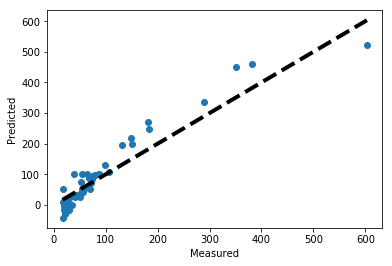

In [33]:
fit_scatter(y_test,lr.predict(X_test))

All on the line

### ========== Question 2.11 ==========
Another way of assessing the performance of the model is to inspect the distribution of the errors. Make a histogram plot by using seaborn's `displot` function. This will also show an estimate of the underlying distribution.

Does it look like the errors are normally distributed? Would you trust the fit of the distribution on the graph? Explain why.

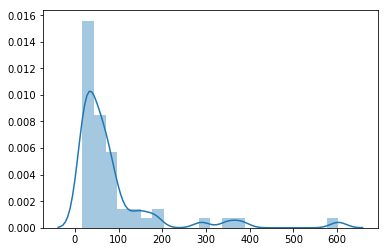

In [34]:
ax = sns.distplot(y_test)

not reely, the fit line is caused by extreme values

### ========== Question 2.12 ==========
Above we deleted the vendor variable. However, we can use nominal attributes in regression by converting them to numeric, exactly in the same way that we did at the first part of this lab. 

Now, use the original `cpu` dataset and convert the `vendor` attribute to numeric by using a `LabelEncoder`. Then train a linear regression model to the data and compare its performance to the one we had previously. Did adding the *binazired vendor* variable help? 

0.85763238563


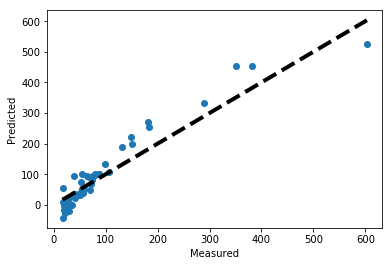

In [36]:
#directly copied from example
le_dict = dict() # Initialise an empty dictionary to keep all LabelEncoders
cpu_clean2 = cpu.copy(deep=True) # Make a copy of the DataFrame
# Loop over attributes by excluding the ones that are continuous and the target variable
le = LabelEncoder().fit(cpu['vendor']) # Initialise the LabelEncoder and fit
cpu_clean2['vendor'] = le.transform(cpu['vendor']) # Transform data and save in credit_clean DataFrame
le_dict['vendor'] = le # Store the LabelEncdoer in dictionary
X2 = cpu_clean2.drop(['ERP'],1).values
y2 = cpu_clean2['ERP'].values
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, train_size = 0.75, test_size=0.25, random_state=0)
lr = LinearRegression()
lr.fit(X_train2,y_train2)
print(lr.score(X_test2,y_test2))
fit_scatter(y_test2,lr.predict(X_test2))

not much really